In [1]:
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(useful)) 
suppressPackageStartupMessages(library(ggplot2)) 
suppressPackageStartupMessages(library(dplyr)) 
suppressPackageStartupMessages(library(limma)) 
suppressPackageStartupMessages(library(EnhancedVolcano)) 
suppressPackageStartupMessages(library(biomaRt)) 
suppressPackageStartupMessages(library(gridExtra)) 
suppressPackageStartupMessages(library(repr)) 

Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired




In [7]:
data <- read.csv("bulk/stability_timepoints_wSC.tsv",sep="\t",header=T,quote="",row.names=1)
corner(data) 
meta <- read.csv("bulk/stability_timepoints_meta_wSC.tsv",sep="\t",header=T,row.names=1,quote="")

,Stability_d21_sample_9,Stability_d21_sample_4,Stability_d21_sample_5,Stability_d21_sample_10,Stability_d21_sample_7
,<int>,<int>,<int>,<int>,<int>
5S_rRNA,0,6,0,0,0
5_8S_rRNA,0,0,0,0,0
7SK,0,0,0,0,1
A1BG,3,6,5,4,21
A1BG-AS1,5,13,11,4,4


In [8]:
dim(data)

[1] 60344    84

In [9]:
dim(meta)

[1] 84  5

In [10]:
head(meta)

,t,sample,t_int,genotype,repl
,<chr>,<int>,<int>,<chr>,<int>
Stability_d21_sample_9,d21,9,21,409B2,1
Stability_d21_sample_4,d21,4,21,409B2,1
Stability_d21_sample_5,d21,5,21,409B2,1
Stability_d21_sample_10,d21,10,21,409B2,1
Stability_d21_sample_7,d21,7,21,409B2,1
Stability_d21_sample_6,d21,6,21,409B2,1


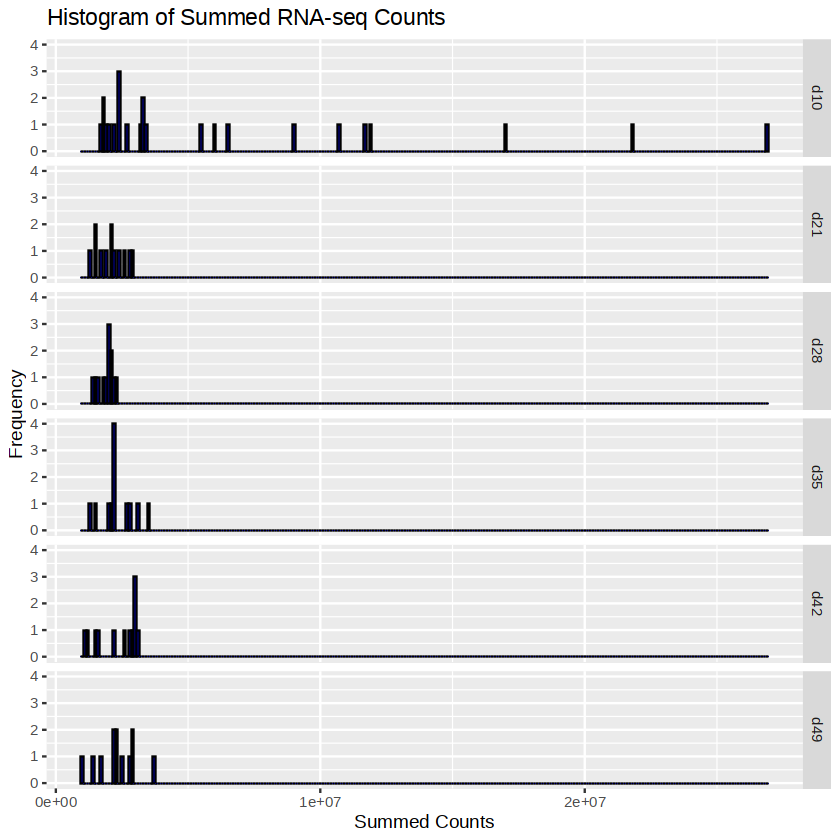

                         counts
Stability_d49_sample_1   992641
Stability_d42_sample_12 1079041
Stability_d42_sample_11 1180100
Stability_d35_sample_1  1284177
Stability_d21_sample_1  1303492
Stability_d49_sample_2  1376227
Stability_d28_sample_5  1426088
Stability_d21_sample_2  1455183
Stability_d35_sample_2  1463416
Stability_d21_sample_9  1490147
Stability_d42_sample_10 1497309
Stability_d28_sample_12 1509340
Stability_d42_sample_9  1621425
Stability_d28_sample_4  1643799
Stability_d21_sample_4  1665449
Stability_d10_sample_12 1697202
Stability_d49_sample_3  1717313
Stability_d28_sample_6  1805606
Stability_d10_sample_11 1819786
Stability_d10_sample_9  1849247


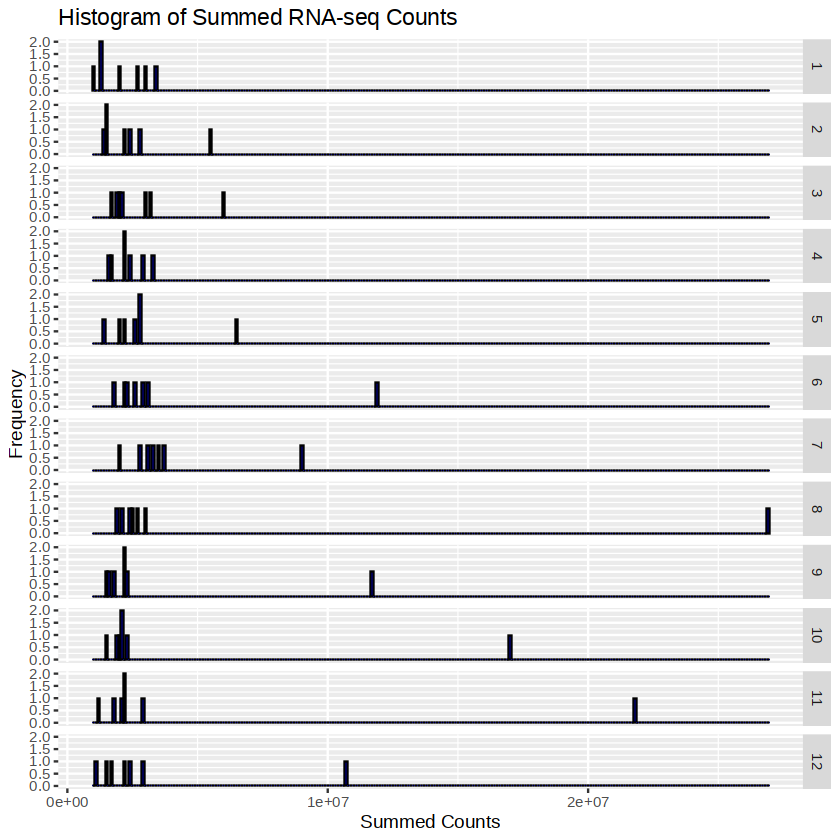

In [11]:

# Load your dataset
# Replace 'your_dataset.csv' with the path to your RNA-seq counts file
# and make sure the column containing counts is correctly specified.

# Assuming the counts are in a column named 'counts'
# Adjust 'counts' to the actual column name in your dataset
counts <- colSums(data)
# Create a dataframe from the counts for easier manipulation and plotting
counts_df <- data.frame(counts = counts)

meta['counts'] <- colSums(data)


# Plot a histogram of the counts
ggplot(meta, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'blue', color = 'black') +
  ggtitle('Histogram of Summed RNA-seq Counts') +
  xlab('Summed Counts') +
  ylab('Frequency') +
  facet_grid(t ~ .)

# Plot a histogram of the counts
ggplot(meta, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'blue', color = 'black') +
  ggtitle('Histogram of Summed RNA-seq Counts') +
  xlab('Summed Counts') +
  ylab('Frequency') +
  facet_grid(sample ~ .)

# Display the lowest count values
lowest_counts <- counts_df %>% 
  arrange(counts) %>% 
  head(20)  # Displaying the 10 lowest counts; adjust as needed

print(lowest_counts)


In [12]:
# Define the minimum count threshold
min_count_threshold <- 1500000  # Replace with your desired threshold
min_count_threshold <- 0  # Replace with your desired threshold

# Filter out samples (columns) with fewer than the minimum threshold counts
filtered_data <- data[, colSums(data) >= min_count_threshold]
filtered_meta <- meta[colSums(data) >= min_count_threshold,]


In [13]:
dim(filtered_meta)

[1] 84  6

In [14]:
dim(filtered_data)

[1] 60344    84

In [15]:
deseq2.colData <- data.frame(row.names=colnames(filtered_data))
#deseq2.colData$pattern <- 'pre'


deseq2.colData <- filtered_meta
deseq2.colData['sums'] <- colSums(filtered_data)

In [16]:
corner(deseq2.colData)

,t,sample,t_int,genotype,repl
,<chr>,<int>,<int>,<chr>,<int>
Stability_d21_sample_9,d21,9,21,409B2,1
Stability_d21_sample_4,d21,4,21,409B2,1
Stability_d21_sample_5,d21,5,21,409B2,1
Stability_d21_sample_10,d21,10,21,409B2,1
Stability_d21_sample_7,d21,7,21,409B2,1


In [17]:
#colData$group <- factor(colData$group)

columns_to_factor <- c("sample","t")
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(all_of(columns_to_factor)), factor)

numeric_columns_to_scale <- c("t_int")
# Scale the specified numeric columns
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(all_of(numeric_columns_to_scale)), ~ scale(log(. + 1)))



In [18]:
deseq2.colData

,t,sample,t_int,genotype,repl,counts,sums
,<fct>,<fct>,"<dbl[,1]>",<chr>,<int>,<dbl>,<dbl>
Stability_d21_sample_9,d21,9,-0.2167039,409B2,1,1490147,1490147
Stability_d21_sample_4,d21,4,-0.2167039,409B2,1,1665449,1665449
Stability_d21_sample_5,d21,5,-0.2167039,409B2,1,2613145,2613145
Stability_d21_sample_10,d21,10,-0.2167039,409B2,1,2140905,2140905
Stability_d21_sample_7,d21,7,-0.2167039,409B2,1,2832186,2832186
Stability_d21_sample_6,d21,6,-0.2167039,409B2,1,2924451,2924451
Stability_d21_sample_1,d21,1,-0.2167039,409B2,1,1303492,1303492
Stability_d21_sample_12,d21,12,-0.2167039,409B2,1,2402694,2402694
Stability_d21_sample_3,d21,3,-0.2167039,409B2,1,1866793,1866793


In [21]:
total <- filtered_data
rownames(deseq2.colData) <- colnames(total)
dds <- DESeqDataSetFromMatrix(countData = total, colData = deseq2.colData,design = ~ t_int + sample + genotype)

#dds <- DESeqDataSetFromMatrix(countData = total, colData = deseq2.colData,design = ~ M_RA)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"


In [22]:
colnames(deseq2.colData)

[1] "t"        "sample"   "t_int"    "genotype" "repl"     "counts"   "sums"

In [23]:
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

# Run Analysis
dds <- DESeq(dds)
res <- results(dds)
res <- res[order(rownames(res)), ]

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [24]:
table(mcols(dds)$betaConv)


 TRUE 
35775 

In [25]:
#save median normalised counts
normalized_counts <- counts(dds, normalized=TRUE)
#write.table(normalized_counts, file="bulk/DESEQ2_norm_counts_stranded.tsv", sep="\t", quote=F, col.names=NA) 

In [26]:
vsd <- vst(dds, blind=FALSE)
#rld <- rlog(dds, blind=FALSE) 
vsd_orig <- vsd

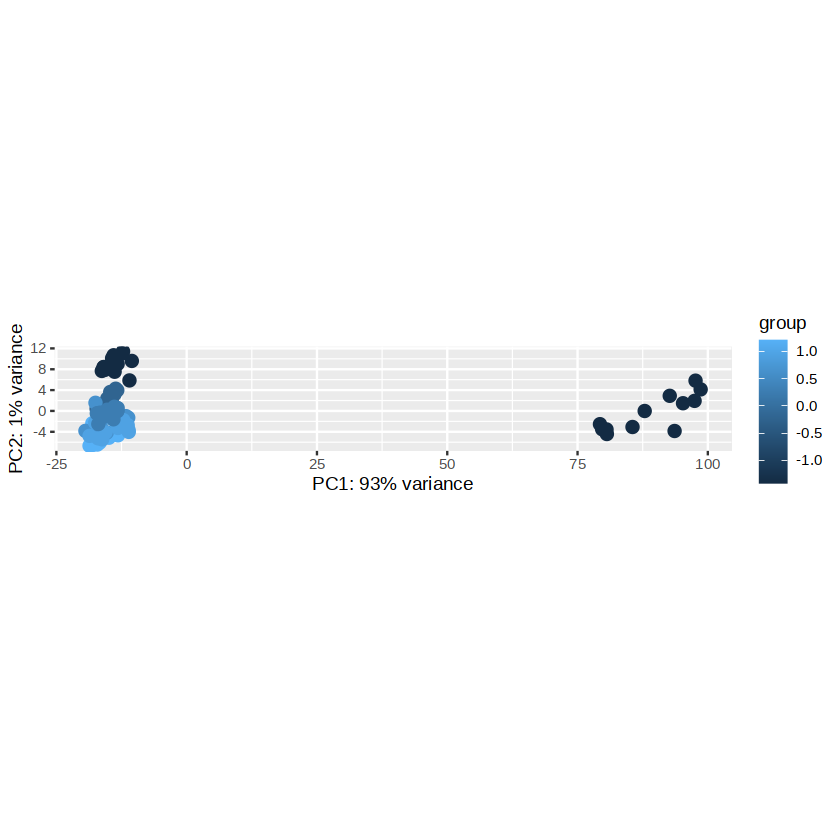

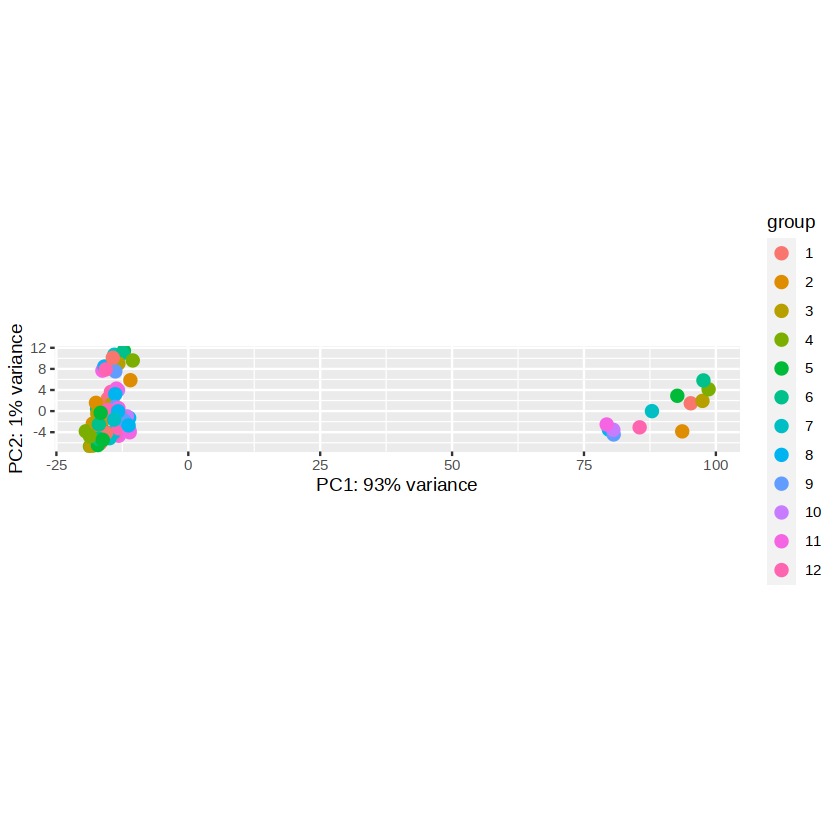

In [27]:
vsd_bk <- vsd
mat <- assay(vsd_bk)
mm <- model.matrix(~t_int, colData(vsd_bk))
mat <- limma::removeBatchEffect(mat, batch=vsd_bk$sample, design=mm)
assay(vsd_bk) <- mat
plotPCA(vsd_bk,intgroup=c('t_int'))
plotPCA(vsd_bk,intgroup=c('sample'))
vsd_samplecorr <- vsd_bk

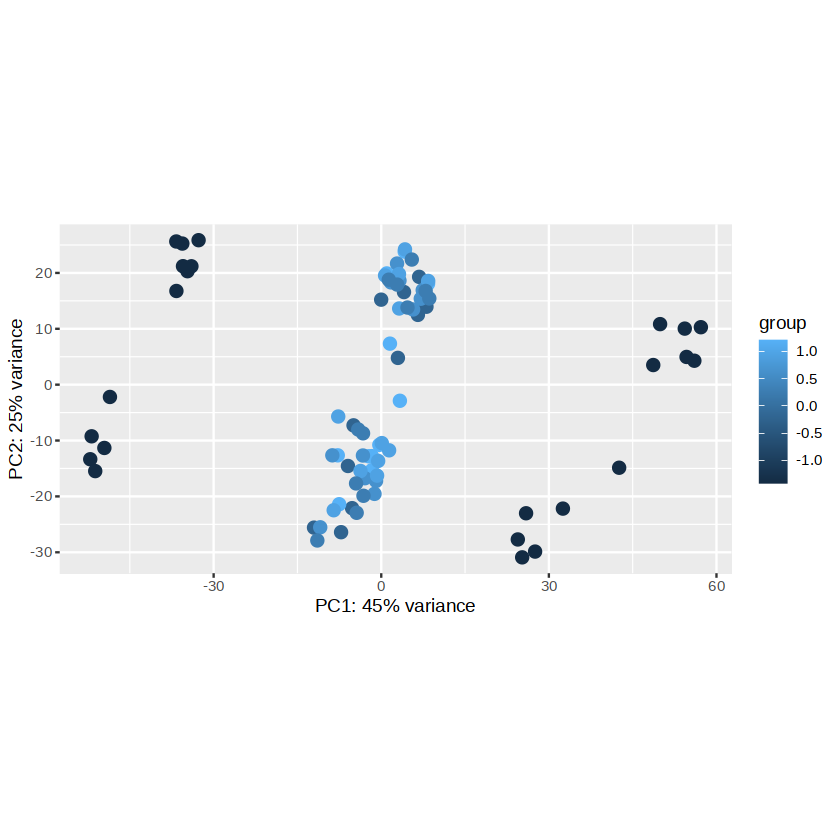

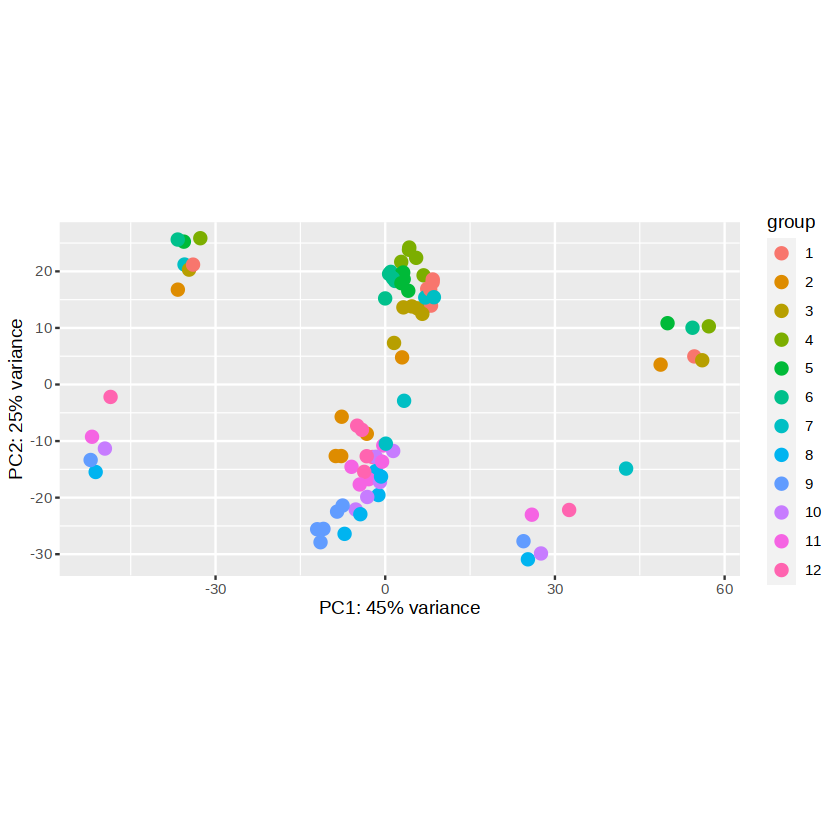

In [28]:
vsd_bk <- vsd
mat <- assay(vsd_bk)
mm <- model.matrix(~sample, colData(vsd_bk))
mat <- limma::removeBatchEffect(mat, batch=vsd_bk$t_int, design=mm)
assay(vsd_bk) <- mat
plotPCA(vsd_bk,intgroup=c('t_int'))
plotPCA(vsd_bk,intgroup=c('sample'))
vsd_tcorr <- vsd_bk

In [44]:
vsd_bk$genotype

[1] 409B2       409B2       409B2       409B2       409B2       409B2      
 [7] 409B2       409B2       409B2       409B2       409B2       409B2      
[13] 409B2       409B2       409B2       409B2       409B2       409B2      
[19] 409B2       409B2       409B2       409B2       409B2       409B2      
[25] 409B2       409B2       409B2       409B2       409B2       409B2      
[31] 409B2       409B2       409B2       409B2       409B2       409B2      
[37] 409B2       409B2       409B2       409B2       409B2       409B2      
[43] 409B2       409B2       409B2       409B2       409B2       409B2      
[49] 409B2       409B2       409B2       409B2       409B2       409B2      
[55] 409B2       409B2       409B2       409B2       409B2       409B2      
[61] 409B2       409B2       409B2       409B2       409B2       409B2      
[67] 409B2       409B2       409B2       409B2       409B2       409B2      
[73] single_cell single_cell single_cell single_cell single_cell single_cell
[79] single_cell single_cell single_cell single_cell single_cell single_cell
Levels: 409B2 single_cell

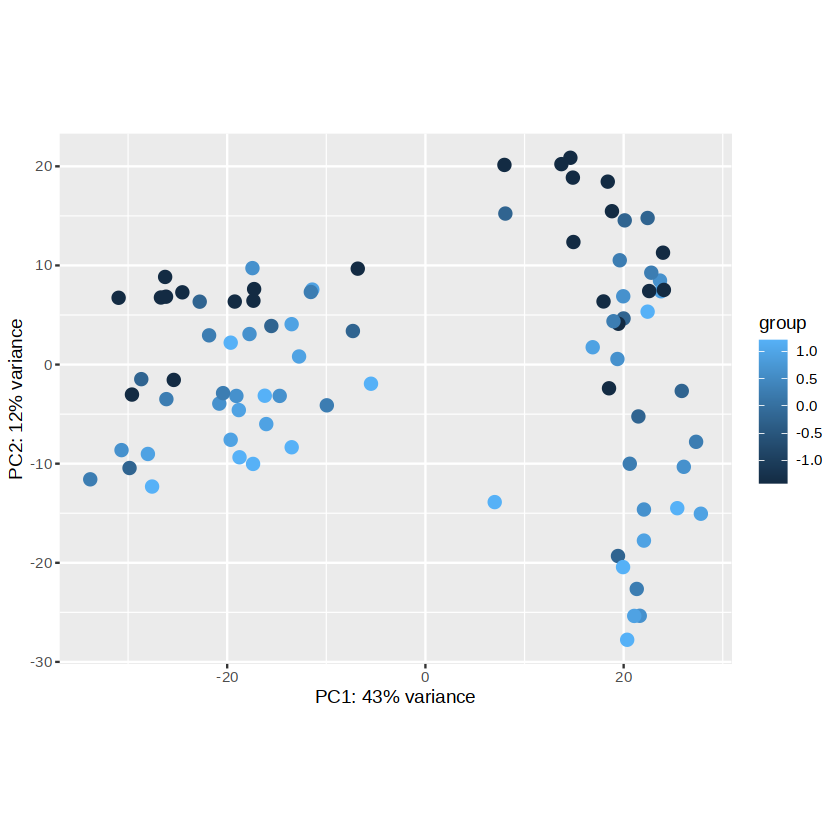

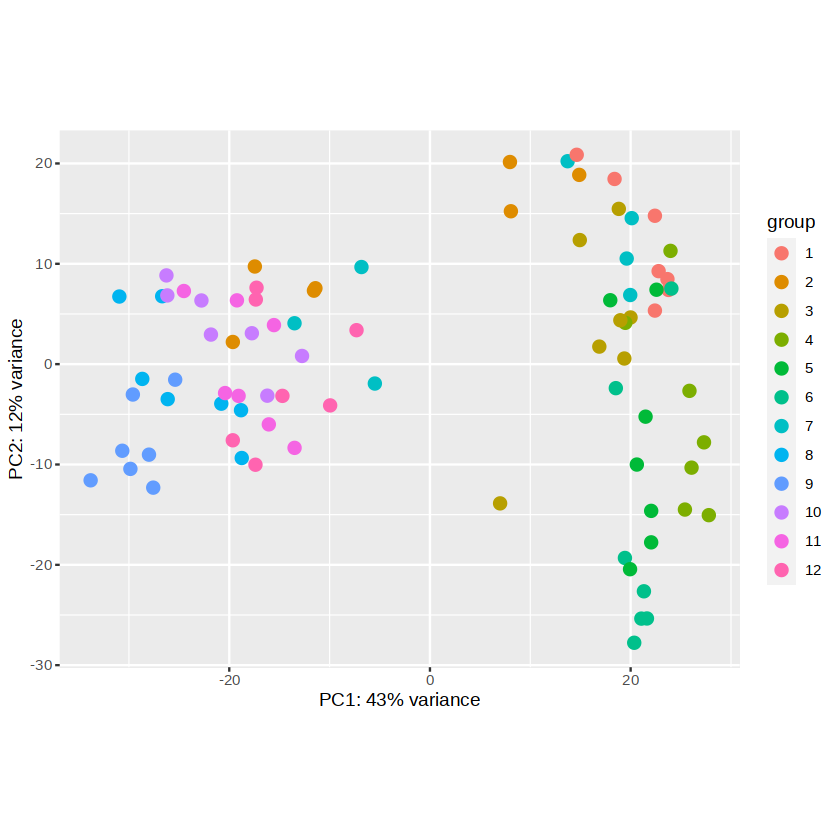

In [32]:
vsd_bk <- vsd
mat <- assay(vsd_bk)
mm <- model.matrix(~t_int, colData(vsd_bk))
mat <- limma::removeBatchEffect(mat, batch=vsd_bk$genotype, design=mm)
assay(vsd_bk) <- mat
plotPCA(vsd_bk,intgroup=c('t_int'))
plotPCA(vsd_bk,intgroup=c('sample'))
vsd_gencorr <- vsd_bk

In [19]:
# Assuming pca_df is your data frame and 'object' is the PCA object used for plotting

# Function to create a PCA plot for a given variable
plotPCA_custom <- function(pca_df, variable) {
  plotPCA(object = pca_df, intgroup = c(variable)) +
    ggtitle(paste('PCA Plot for', variable))
}

# List of variables to plot
variables <- c('M_BMP4', 'M_SHH', 'M_RA', 'M_CHIR', 'M_XAV', 'M_FGF8')

# Set plot size
options(repr.plot.width=15, repr.plot.height=10)

# Generate a list of PCA plots
plots <- lapply(variables, function(var) plotPCA_custom(vsd, var))

# Arrange the plots in a grid (2 rows, 3 columns)
grid.arrange(grobs = plots, ncol = 3)


ERROR: Error in .local(object, ...): the argument 'intgroup' should specify columns of colData(dds)


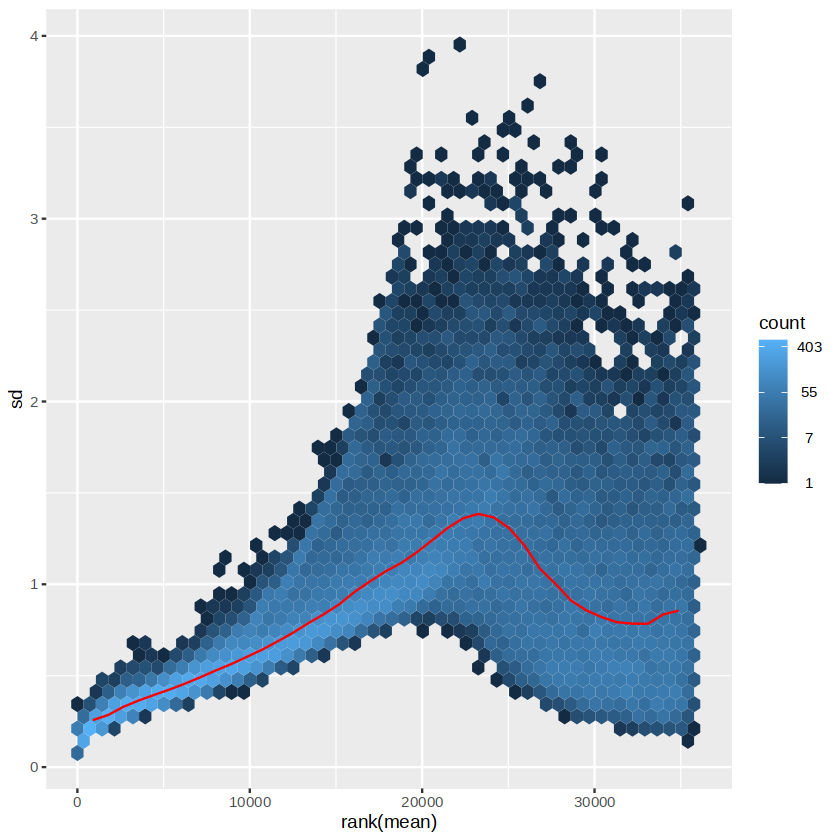

In [29]:
# this gives log2(n + 1)
ntd <- normTransform(dds)
library("vsn")
meanSdPlot(assay(ntd)) 

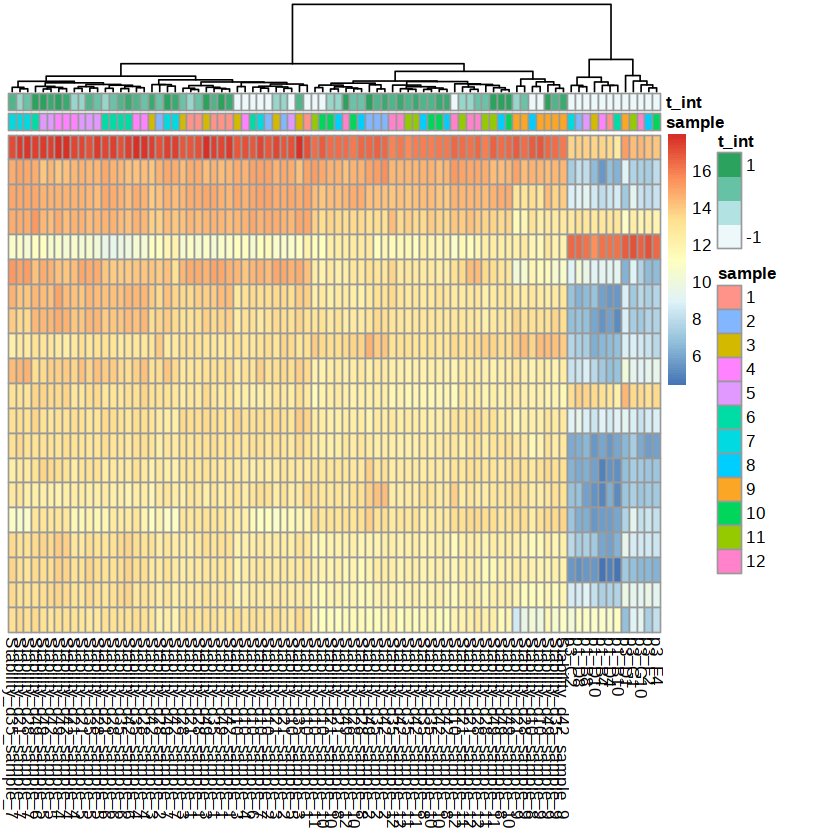

In [30]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("sample","t_int")])
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)

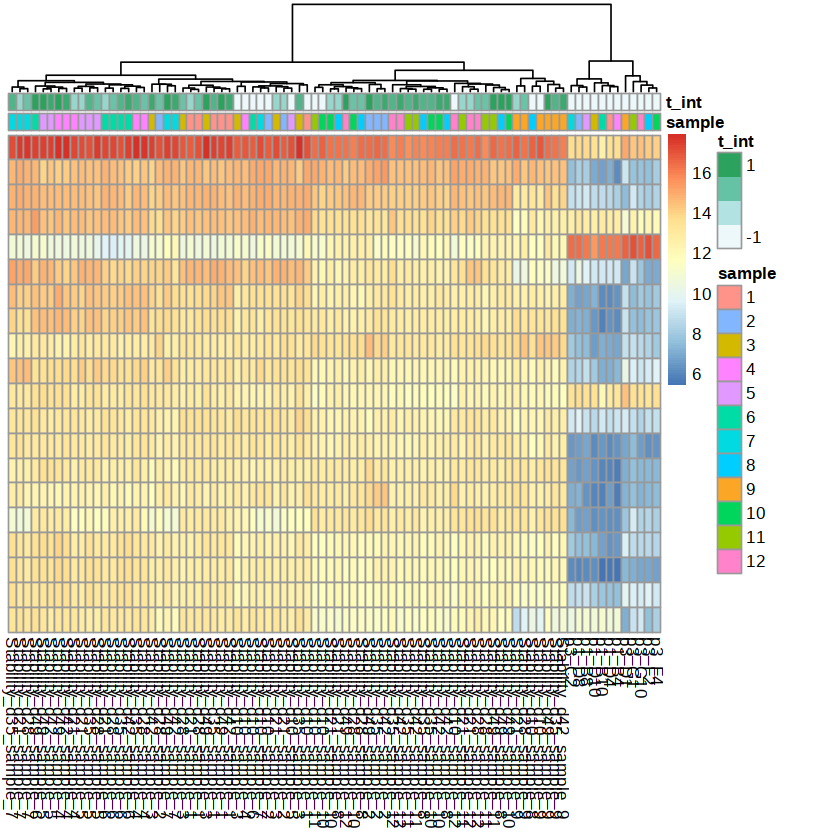

In [31]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("sample","t_int")])
pheatmap(assay(vsd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)

In [23]:
# Assuming you have already created the DESeqDataSet object `dds`
# Normalize and transform the data
vsd <- vst(dds, blind = FALSE)

# Extract the transformed counts
transformed_counts <- assay(vsd)

# Get the sample information
sample_info <- colData(vsd)

# Compute Euclidean distances
euclidean_distance <- function(x, y) {
  sqrt(sum((x - y)^2))
}

# Calculate distances between matching conditions
matching_distances <- sapply(1:82, function(i) {
  sample1 <- transformed_counts[, sample_info$batch == "Batch1" & sample_info$condition == paste0("Condition", i)]
  sample2 <- transformed_counts[, sample_info$batch == "Batch2" & sample_info$condition == paste0("Condition", i)]
  euclidean_distance(sample1, sample2)
})

# Calculate distances between random pairs of samples
set.seed(123) # For reproducibility
random_distances <- replicate(82, {
  random_sample1 <- transformed_counts[, sample(sample_info$sampleID, 1)]
  random_sample2 <- transformed_counts[, sample(sample_info$sampleID, 1)]
  euclidean_distance(random_sample1, random_sample2)
})

# Combine distances into a data frame
distances_df <- data.frame(
  Distance = c(matching_distances, random_distances),
  Type = rep(c("Matching", "Random"), each = 82)
)

# Plot the distances
ggplot(distances_df, aes(x = Type, y = Distance, fill = Type)) +
  geom_boxplot() +
  ggtitle("Comparison of Distances Between Matching and Random Samples") +
  ylab("Euclidean Distance") +
  theme_bw()


ERROR: Error in sample.int(length(x), size, replace, prob): invalid first argument


In [33]:
sampleDists <- dist(t(assay(vsd_orig)))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_pca_distances_noFilter_wSC.tsv",sep = "\t")

sampleDists <- dist(t(assay(vsd_samplecorr)))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_limma_corrS_pca_distances_noFilter_wSC.tsv",sep = "\t")

sampleDists <- dist(t(assay(vsd_tcorr)))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_limma_corrT_pca_distances_noFilter_wSC.tsv",sep = "\t")

sampleDists <- dist(t(assay(vsd_gencorr)))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_limma_corrG_pca_distances_noFilter_wSC.tsv",sep = "\t")


In [34]:
write.table(assay(vsd_orig),"bulk/stability_time_deseq2_vsd_noFilter_wSC.tsv",sep = "\t")
write.table(assay(vsd_samplecorr),"bulk/stability_time_deseq2_vsd_corrS_noFilter_wSC.tsv",sep = "\t")
write.table(assay(vsd_tcorr),"bulk/stability_time_deseq2_vsd_corrT_noFilter_wSC.tsv",sep = "\t")
write.table(assay(vsd_gencorr),"bulk/stability_time_deseq2_vsd_corrT_noFilter_wSC.tsv",sep = "\t")


In [37]:
marker_genes <- read.csv("sample_markers_all_sc_set_top3_10genes.txt",sep="\t",header=F,quote="",row.names=1)
marker_genes <- row.names(marker_genes)

In [40]:
sampleDists <- dist(t(assay(vsd_gencorr)[marker_genes,]))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_limma_corrG_pca_distances_noFilter_wSC_markers.tsv",sep = "\t")


In [42]:
marker_genes <- read.csv("sample_markers_all_sc_set_top3_10genes_bulk.txt",sep="\t",header=F,quote="",row.names=1)
marker_genes <- row.names(marker_genes)

In [43]:
sampleDists <- dist(t(assay(vsd_gencorr)[marker_genes,]))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/stability_time_deseq2_limma_corrG_pca_distances_noFilter_wSC_markers_bulk.tsv",sep = "\t")


In [ ]:
plotPCA(vsd_bk,intgroup=c('t_int'))


In [36]:
assay(vsd_orig)

,Stability_d21_sample_9,Stability_d21_sample_4,Stability_d21_sample_5,Stability_d21_sample_10,Stability_d21_sample_7,Stability_d21_sample_6,Stability_d21_sample_1,Stability_d21_sample_12,Stability_d21_sample_3,Stability_d21_sample_2,⋯,p1_D10,p1_B4,p1_B8,p1_B10,p3_C2,p3_F2,p3_D1,p3_F4,p3_G1,p3_G10
5S_rRNA,3.722420,4.889471,3.722420,3.722420,3.722420,3.722420,4.479013,3.722420,3.722420,3.722420,⋯,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420
7SK,3.722420,3.722420,3.722420,3.722420,4.107052,3.722420,3.722420,3.722420,3.722420,3.722420,⋯,7.396902,5.981879,7.387867,5.703562,6.401743,7.004663,8.620084,7.134708,7.824497,9.673770
A1BG,4.582439,4.889471,4.588095,4.516734,5.394994,5.031610,4.780813,4.797529,5.360614,5.550782,⋯,4.502936,4.828388,4.519670,4.550582,4.726168,4.616060,4.586906,4.637091,4.449171,4.472296
A1BG-AS1,4.822376,5.392646,4.985086,4.516734,4.485054,5.121943,5.189034,4.972953,4.987469,5.363780,⋯,5.760041,5.953813,5.937428,5.920334,5.831532,5.575619,5.648696,5.596929,5.594516,5.698799
A1CF,4.223809,3.722420,4.114191,3.722420,4.264784,3.722420,3.722420,4.110216,3.722420,3.722420,⋯,4.176688,4.149190,4.355656,4.039115,4.294174,4.092095,4.070251,4.002406,4.010022,3.932561
A2M,5.793520,5.058769,5.225425,5.662701,8.010637,4.762374,4.643962,5.856307,4.369955,6.703507,⋯,4.855985,4.749760,4.566731,4.578837,5.182008,4.779354,4.897509,4.839164,4.550877,5.096410
A2M-AS1,6.240840,5.785466,5.037702,5.382434,4.789086,5.664249,5.346538,5.167680,5.906895,4.241628,⋯,4.973068,5.301339,4.900559,4.838531,5.063575,5.382705,4.564489,5.082894,5.213225,5.053871
A2ML1,4.428012,3.722420,4.498963,4.287585,3.722420,3.722420,4.260441,3.722420,3.722420,4.612396,⋯,4.176688,3.722420,4.289699,4.389619,4.294174,4.466998,4.384261,4.279799,4.218933,4.190668
A2ML1-AS1,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420,⋯,5.009223,5.519503,5.147163,5.331756,4.970042,5.286794,4.782483,5.208739,5.165339,5.321859
A2MP1,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420,3.722420,4.110216,3.722420,3.722420,⋯,4.502936,4.323803,4.469334,4.550582,4.381215,4.741349,4.629891,4.623566,4.794550,4.526564


,Stability_d21_sample_4,Stability_d21_sample_5,Stability_d21_sample_10,Stability_d21_sample_7,Stability_d21_sample_6,Stability_d21_sample_12,Stability_d21_sample_3,Stability_d21_sample_11,Stability_d21_sample_8,Stability_d49_sample_4,⋯,Stability_d28_sample_9,Stability_d28_sample_10,Stability_d28_sample_11,Stability_d28_sample_1,Stability_d28_sample_2,Stability_d28_sample_3,Stability_d28_sample_12,Stability_d28_sample_8,Stability_d28_sample_7,Stability_d28_sample_6
5S_rRNA,4.707781,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,⋯,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,4.001686,3.479777,3.479777,3.479777
7SK,3.479777,3.479777,3.479777,3.881889,3.479777,3.479777,3.479777,3.479777,3.907780,3.479777,⋯,3.901125,3.922421,3.919562,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777
A1BG,4.707781,4.388433,4.319476,5.220857,4.849354,4.609297,5.192522,4.825000,4.792458,4.497537,⋯,4.204525,4.769542,4.761659,5.008578,4.762146,4.552930,4.726056,4.725551,5.482760,4.996429
A1BG-AS1,5.232599,4.803043,4.319476,4.276445,4.943247,4.792579,4.804809,5.165983,4.509986,5.015799,⋯,4.073573,4.699984,4.537361,4.948671,4.888043,4.552930,4.819501,4.862713,5.191316,5.403789
A1CF,3.479777,3.891492,3.479777,4.046638,3.479777,3.888037,3.479777,3.898757,4.215813,3.479777,⋯,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777
A2M,4.884767,5.053099,5.518409,7.884929,4.568913,5.709027,4.159520,4.704071,4.852178,5.530987,⋯,4.494492,5.415590,4.448667,5.065475,6.589497,3.926277,4.001686,4.117005,8.850422,4.674949
A2M-AS1,5.639698,4.857851,5.227040,4.592983,5.504672,4.995555,5.756700,5.078524,5.109954,5.492061,⋯,5.569377,5.415590,4.349525,5.796504,4.537770,5.961718,5.128939,5.763103,5.682994,5.670620
A2ML1,3.479777,4.295110,4.077663,3.479777,3.479777,3.479777,3.479777,3.898757,3.479777,3.479777,⋯,3.479777,3.479777,3.479777,3.940090,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777
A2MP1,3.479777,3.479777,3.479777,3.479777,3.479777,3.888037,3.479777,3.479777,3.479777,3.479777,⋯,3.479777,4.454785,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777,3.479777
A4GALT,5.549486,5.616097,4.897107,4.927680,5.323179,5.513138,5.607994,4.404053,4.326711,6.516409,⋯,3.479777,4.625182,4.537361,5.221189,5.549686,5.308822,5.529378,4.117005,5.566609,5.629804


In [32]:
vsd

class: DESeqTransform 
dim: 28587 61 
metadata(1): version
assays(1): ''
rownames(28587): 5S_rRNA 7SK ... ZZEF1 ZZZ3
rowData names(66): baseMean baseVar ... maxCooks dispFit
colnames(61): Stability_d21_sample_4 Stability_d21_sample_5 ...
  Stability_d28_sample_7 Stability_d28_sample_6
colData names(6): t sample ... sums sizeFactor

In [51]:
library(repr)



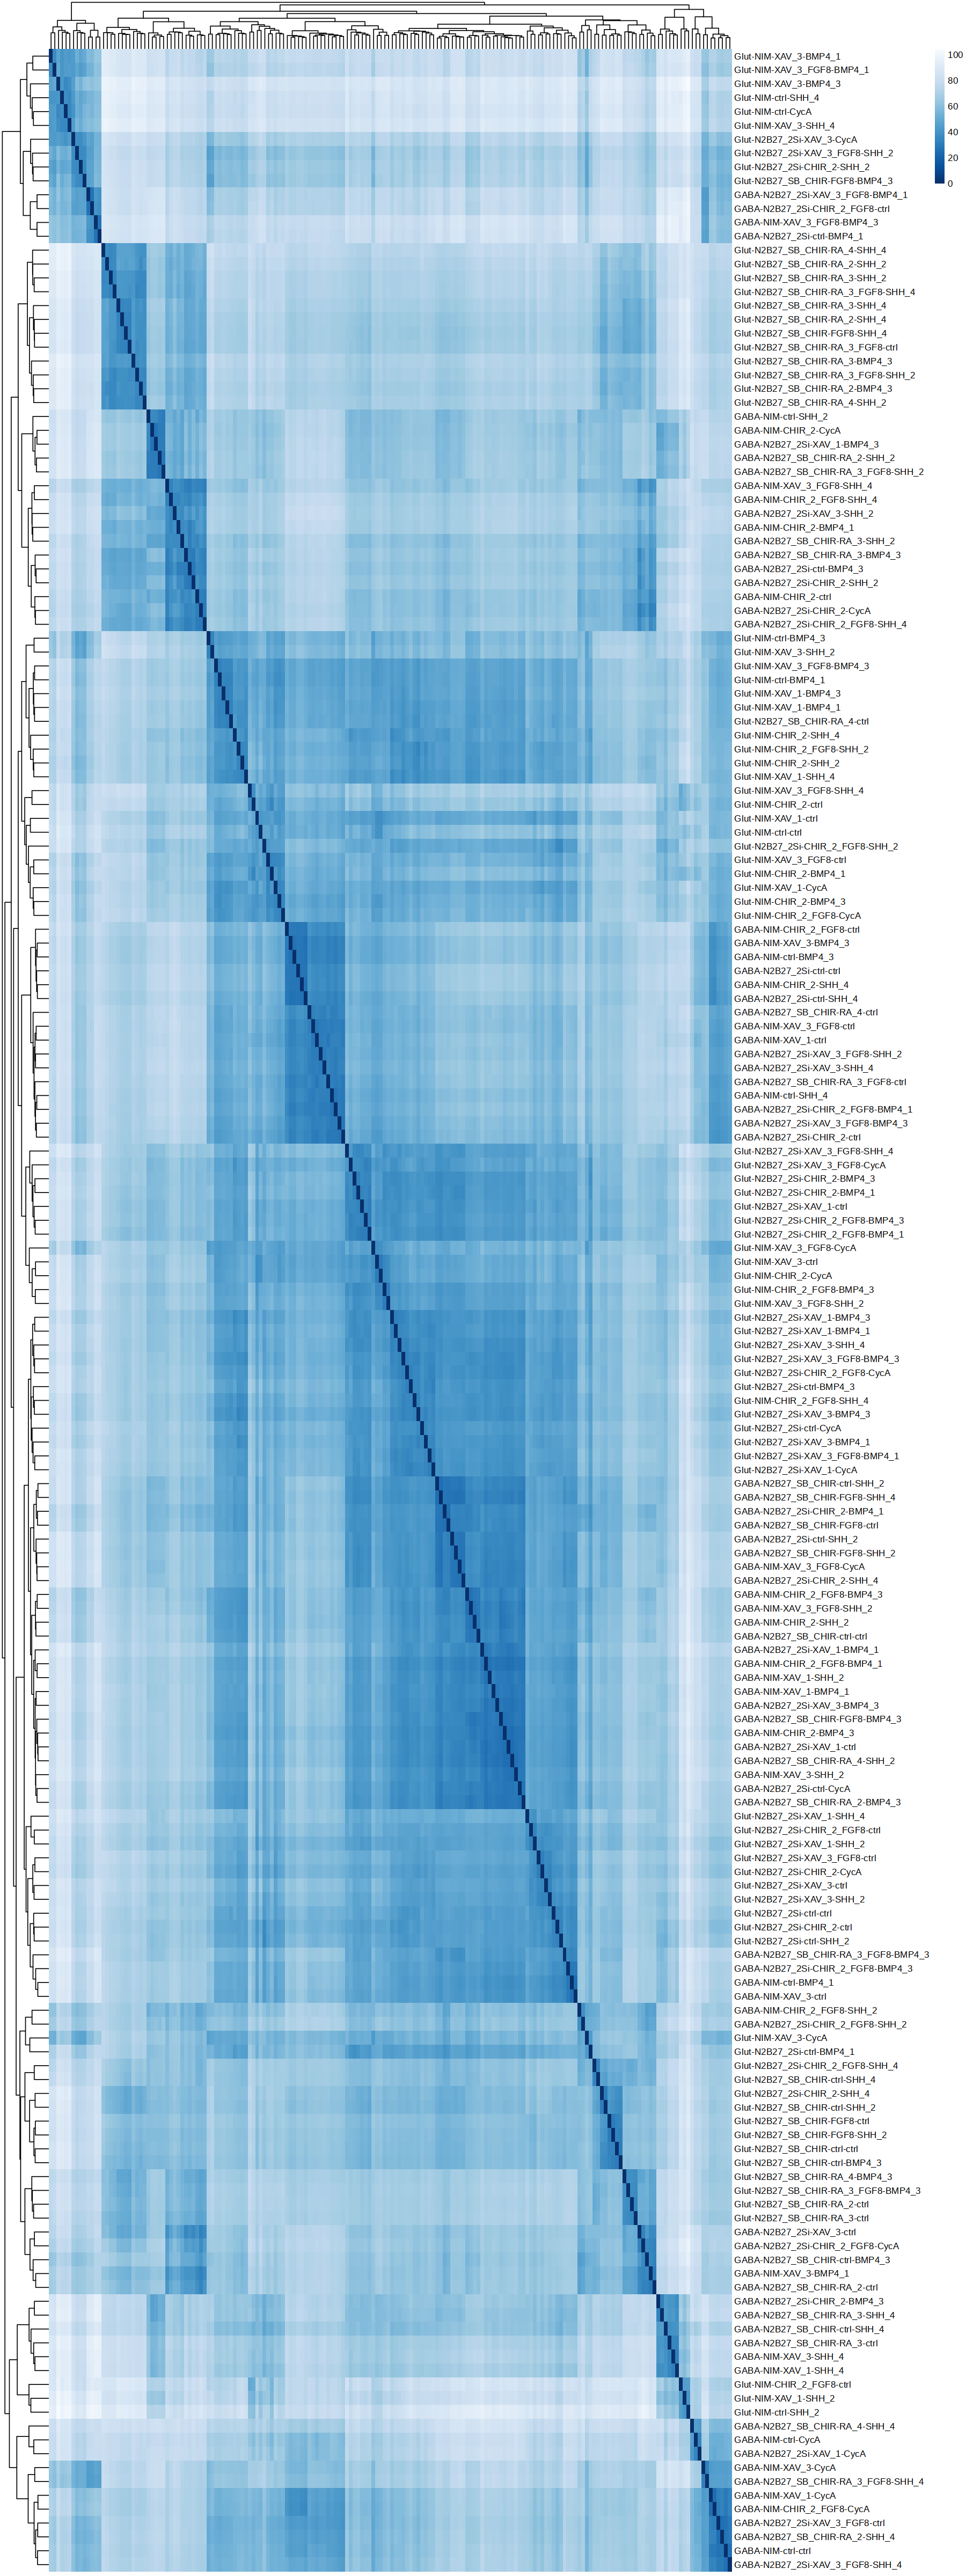

In [54]:
library("RColorBrewer")
sampleDistMatrix <- as.matrix(sampleDists)

rownames(sampleDistMatrix) <- paste(vsd$TF,vsd$Basal_media, vsd$AP_axis, vsd$DV_axis, sep="-")
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

# Set plot size
options(repr.plot.width=15, repr.plot.height=40)

pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors)

In [67]:
colnames(mm)

[1] "(Intercept)"              "M_RA"                    
[3] "M_XAV"                    "M_CHIR"                  
[5] "M_FGF8"                   "M_BMP4"                  
[7] "M_SHH"                    "Basal_mediaN2B27_SB_CHIR"
[9] "Basal_mediaNIM"

In [80]:
resAshT

log2 fold change (MMSE): M RA 
Wald test p-value: M RA 
DataFrame with 26046 rows and 5 columns
          baseMean log2FoldChange     lfcSE    pvalue      padj
         <numeric>      <numeric> <numeric> <numeric> <numeric>
A1BG     11.078487    0.000951472 0.0417937 0.9546671  0.983994
A1BG-AS1  3.003253   -0.022025185 0.0565259 0.1953668  0.495439
A1CF      0.314303    0.001924723 0.0674353 0.8393419        NA
A2M       4.446005    0.068560869 0.0942524 0.0159569  0.150561
A2M-AS1   3.967147   -0.006915710 0.0466550 0.6472442  0.843689
...            ...            ...       ...       ...       ...
ZYG11A     8.57726     0.02341255 0.0625491 0.1669396  0.462168
ZYG11B   115.37802    -0.00606248 0.0237642 0.7375706  0.887511
ZYX      175.03781     0.07047382 0.0834436 0.0128983  0.137026
ZZEF1     36.65814     0.00902080 0.0305574 0.6531622  0.847524
ZZZ3     302.21323    -0.02490163 0.0176660 0.0907511  0.350278

In [73]:
res_M_RA <- results(dds, name = "M_RA")
resAshT <- lfcShrink(dds,res=res_M_RA, coef=2, type="ashr", lfcThreshold=1)

In [102]:
cname <- "M_CHIR"
res_M_RA <- results(dds, name = cname)
resApe = lfcShrink(dds,res=res_M_RA,coef = cname,type="apeglm", lfcThreshold=1)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

computing FSOS 'false sign or small' s-values (T=1)



In [106]:
resApe

log2 fold change (MAP): M CHIR 
 
DataFrame with 26046 rows and 4 columns
          baseMean log2FoldChange      lfcSE    svalue
         <numeric>      <numeric>  <numeric> <numeric>
A1BG     11.078487   -0.000584181 0.00933743  0.938416
A1BG-AS1  3.003253   -0.000272153 0.00932950  0.939425
A1CF      0.314303    0.000120784 0.00934962  0.940402
A2M       4.446005    0.000619178 0.00934987  0.941348
A2M-AS1   3.967147    0.000363301 0.00933816  0.942265
...            ...            ...        ...       ...
ZYG11A     8.57726   -0.000542641 0.00935357  0.999858
ZYG11B   115.37802    0.000633110 0.00894191  0.999858
ZYX      175.03781   -0.002916402 0.00998571  0.999858
ZZEF1     36.65814   -0.002135274 0.00947873  0.999858
ZZZ3     302.21323    0.019338482 0.02287828  0.999858

In [105]:
res_M_RA

log2 fold change (MLE): M CHIR 
Wald test p-value: M CHIR 
DataFrame with 26046 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat     pvalue      padj
         <numeric>      <numeric> <numeric> <numeric>  <numeric> <numeric>
A1BG     11.078487     -0.0683902 0.0988031 -0.692187   0.488820  0.999957
A1BG-AS1  3.003253     -0.0736893 0.1245498 -0.591645   0.554088  0.999957
A1CF      0.314303      0.1309667 0.4568507  0.286673   0.774363  0.999957
A2M       4.446005      0.0165454 0.1159063  0.142748   0.886489  0.999957
A2M-AS1   3.967147      0.0780098 0.1346004  0.579566   0.562208  0.999957
...            ...            ...       ...       ...        ...       ...
ZYG11A     8.57726    -0.13051017 0.1459803 -0.894026 0.37130807  0.999957
ZYG11B   115.37802     0.00616459 0.0294312  0.209458 0.83409083  0.999957
ZYX      175.03781    -0.28521676 0.0926346 -3.078945 0.00207735  0.490978
ZZEF1     36.65814    -0.05092152 0.0434352 -1.172357 0.24105376  0.999957
Z

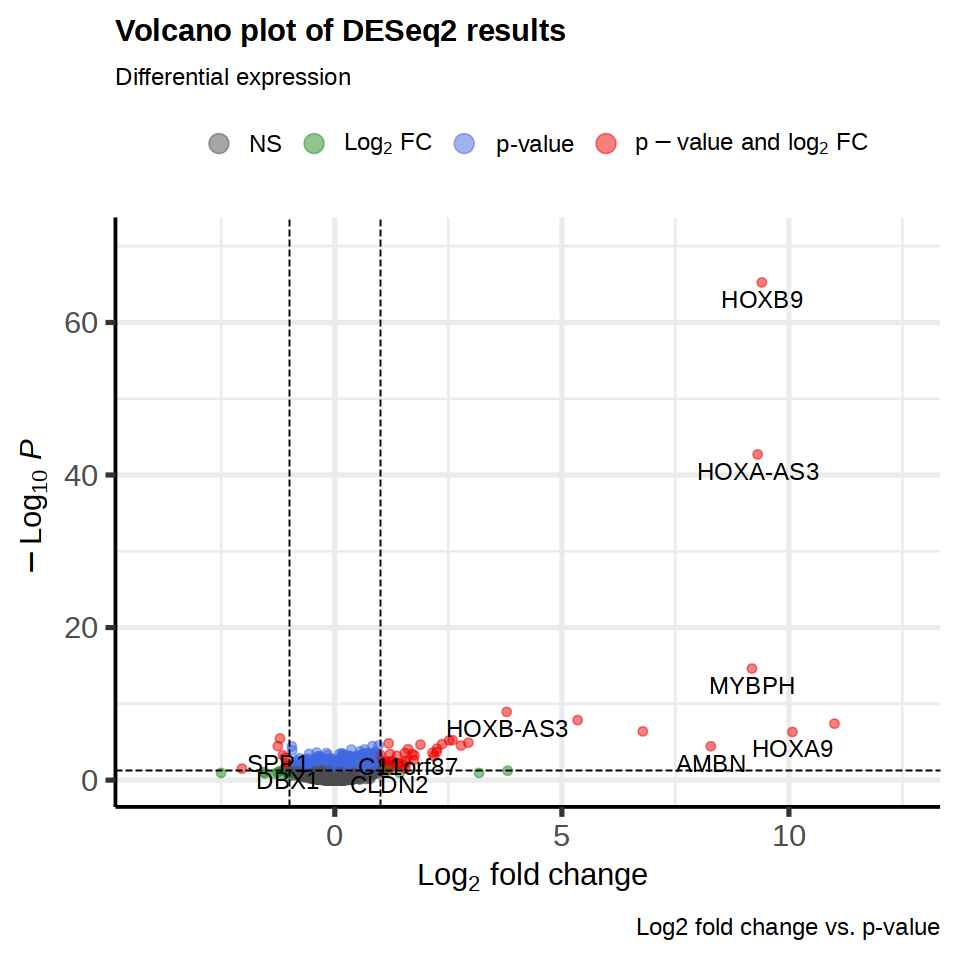

In [103]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



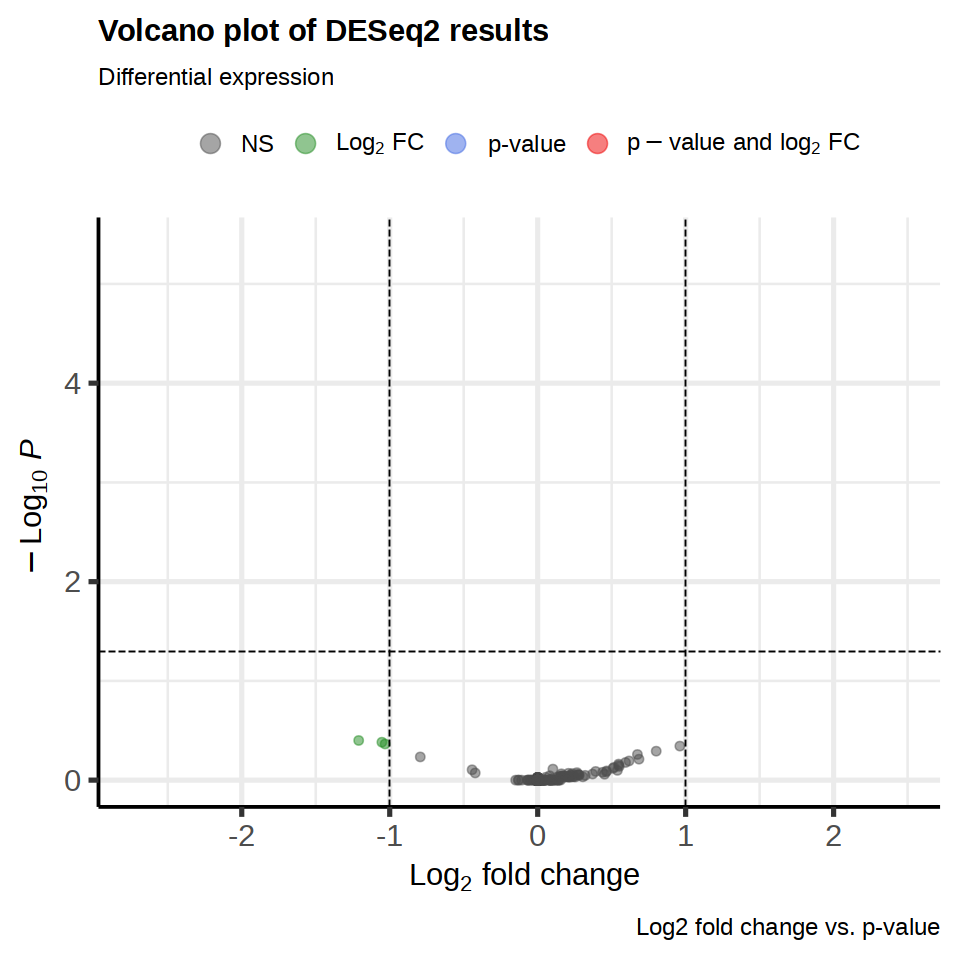

In [104]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



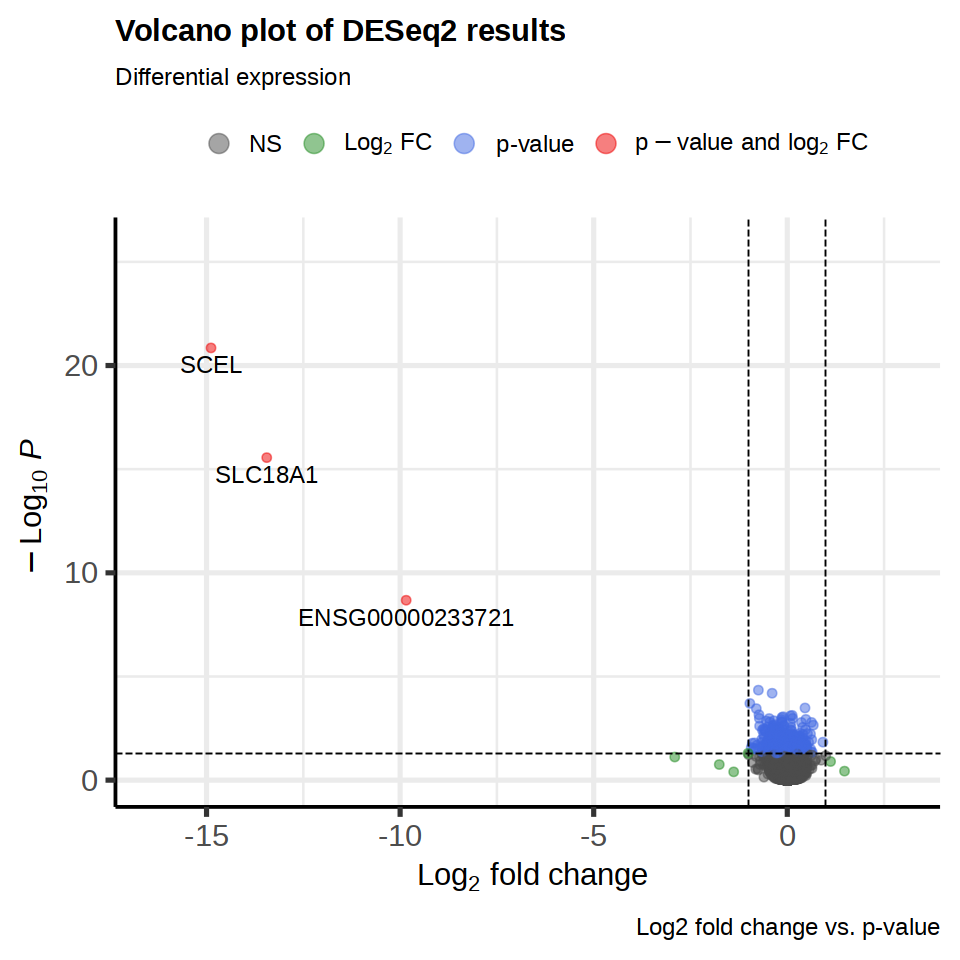

In [98]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



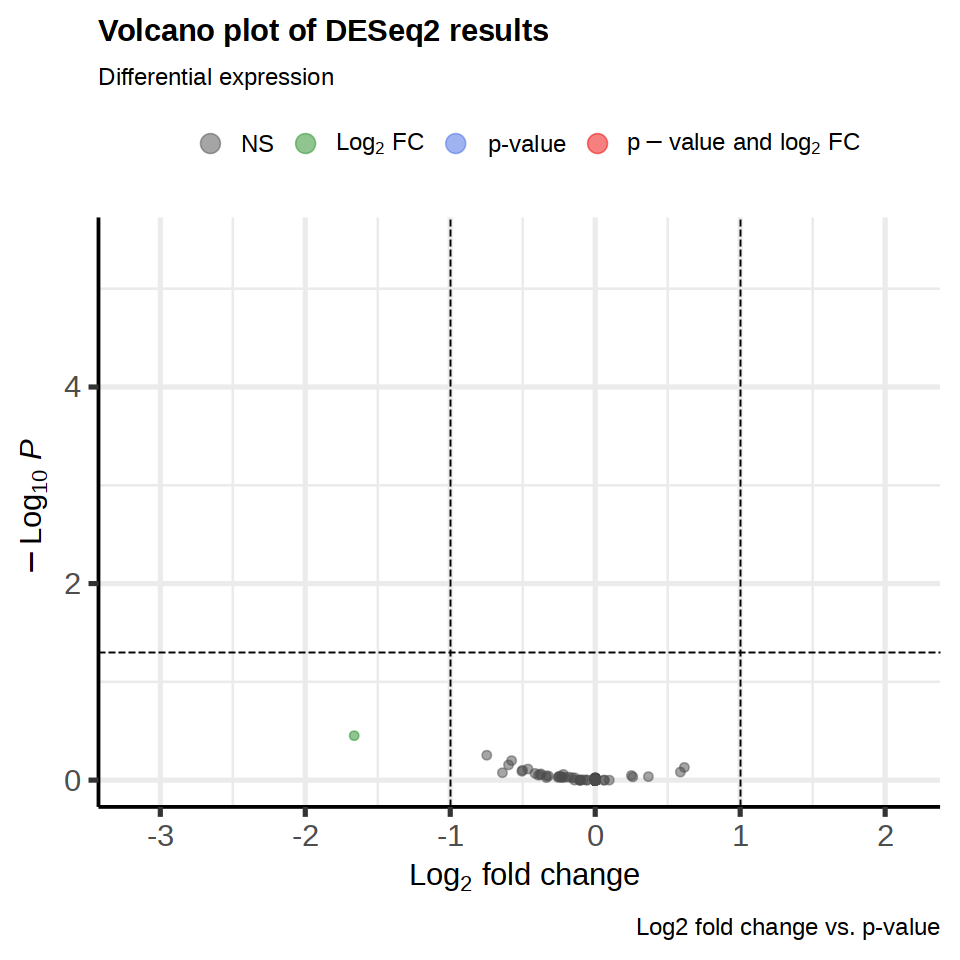

In [96]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



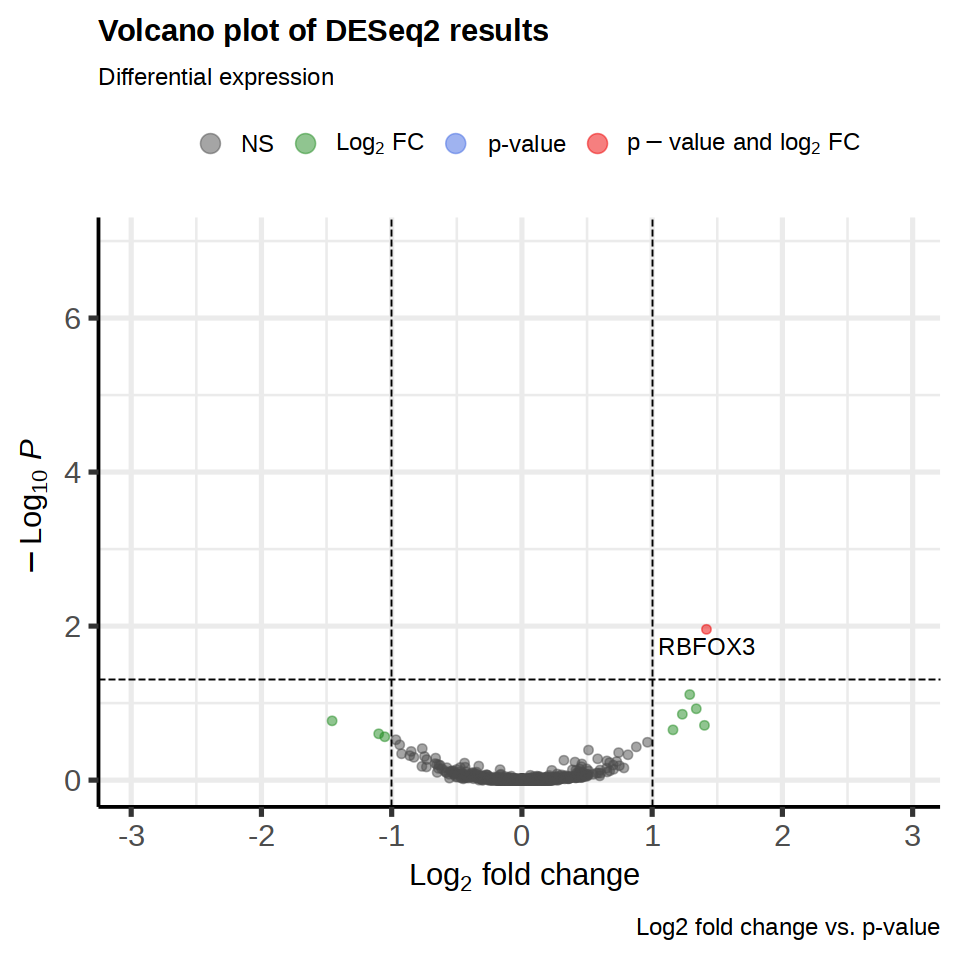

In [93]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



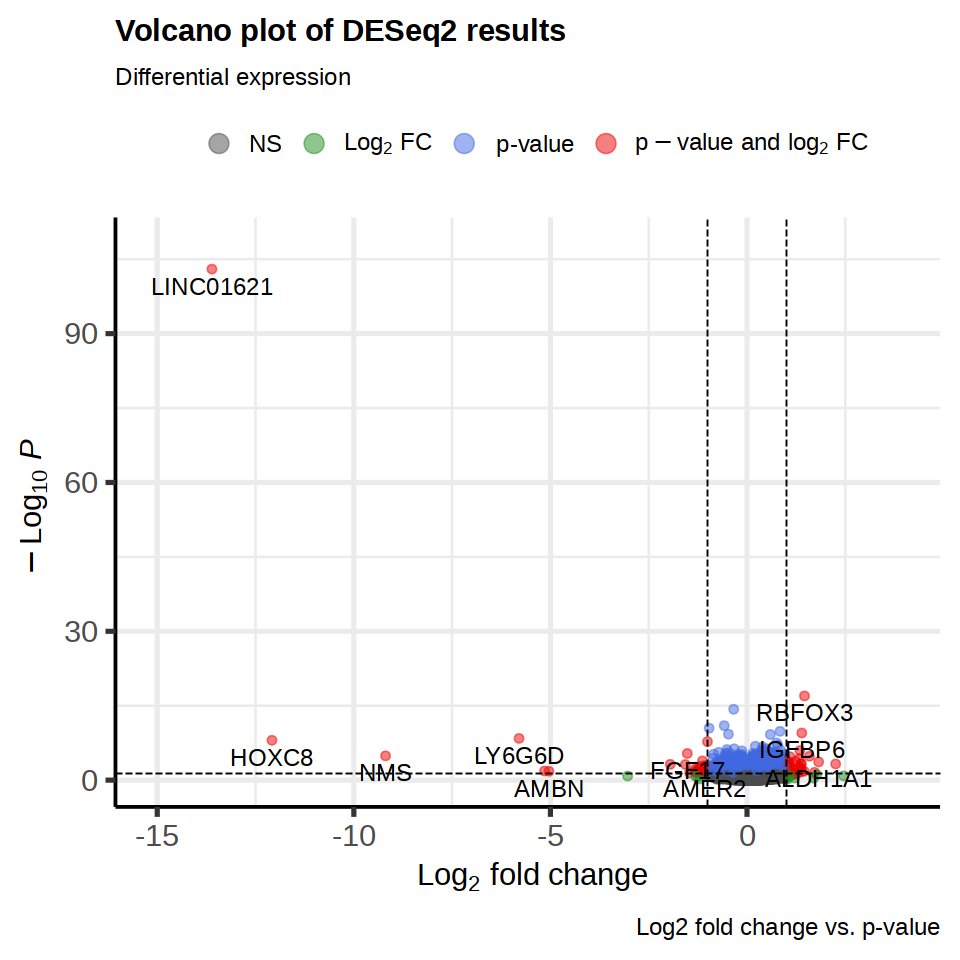

In [82]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')


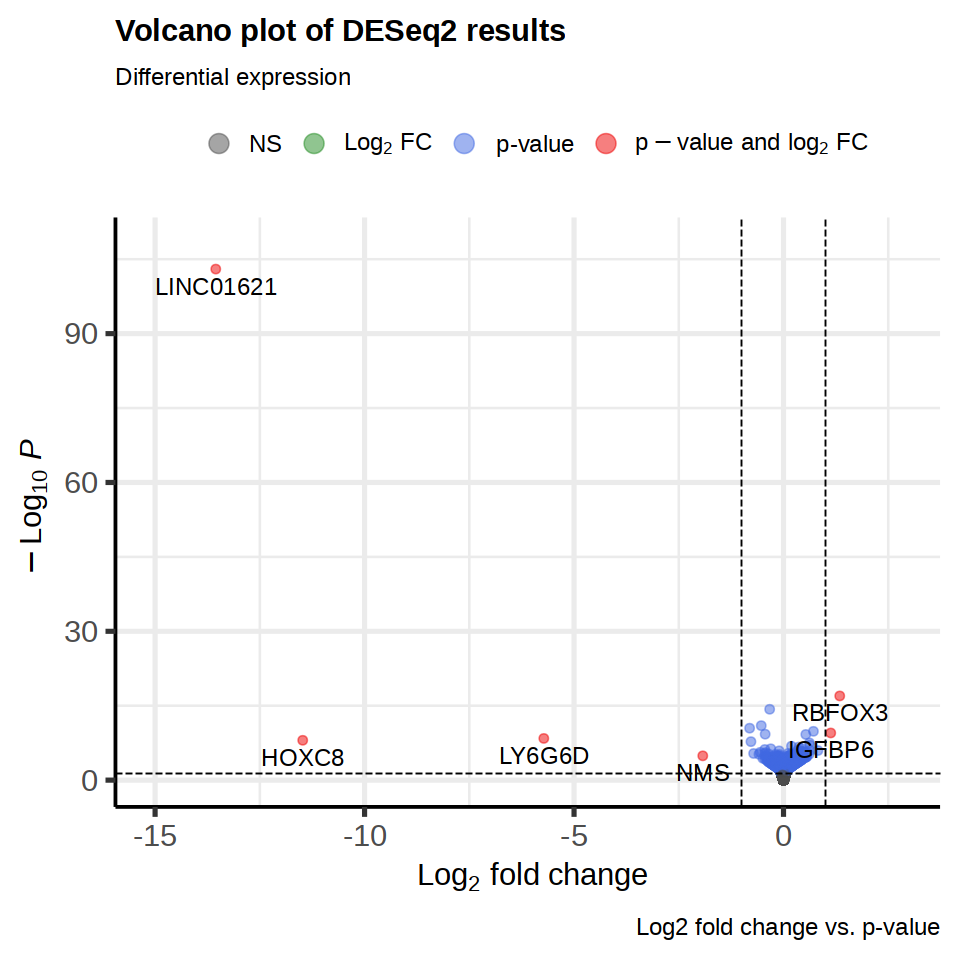

In [81]:
# Get results
res <- resAshT

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')


In [93]:
table(vsd_l@colData$M_RA)


-0.247023184533617 -0.195228000679794  0.270928654004612   4.93249520084867 
               151                  8                 16                  7 

In [56]:
table(vsd@colData$M_RA)


-0.42279543647209 0.882246098889301  2.08895894809182  3.33725699238602 
              151                 8                16                 7 